In [ ]:
# %% Import everything 

import cgt 
import pickle
from cgt import * 

import cgt.simulations 

import cgt.parsers 

import splitp as sp 

import numpy as np 
import pandas as pd

from splitp import phylogenetics 

from cgt.distances import likelihood_function, maximise, mle, mles 

import phylodm 

from phylodm import * 

from matplotlib import pyplot 



  

def my_sim(newick, number, probabilities, compare, numbers): 



        # %% Newick: newick tree notation of phylogenetic tree " "(A:1,B:1);" " 

        # %% Number: number of evolution simulations to be completed " 10 " 

        # %% Probabilities: rearrangement model used in evolving new genomes  

        # " {MODEL.all_inversions:1/2, MODEL.two_region_adjacent_transpositions: 1/2, MODEL.one_region_inversions: 0, 

        # MODEL.one_region_swaps: 0, MODEL.two_region_inversions: 0} " 

        # %% Compare: model to use for maximum likelihood time estimates - same form as probabilities      



    # %% Generate distance matrix of newick tree 
    with open('/tmp/newick.tree', 'w') as fh: 
        fh.write(newick) 
    pdm = PhyloDM.load_from_newick_path('/tmp/newick.tree') 
    dm = pdm.dm(norm=False) 
    print(np.around(dm, decimals=2, out=None)) 

  

    # %% Define framework and model 

    framework = cgt.PositionParadigmFramework(numbers, oriented=True, symmetry=SYMMETRY.circular)  

    model = cgt.Model(framework, probabilities)   

    model2 = cgt.Model(framework, compare)   
    tree = cgt.simulations.newick_to_tree(newick) 
    cgt.simulations.draw_tree(tree)
    
    nan_count=0
    all_genomes=[] 
    all_distances=[] 
    all_minimums=[] 
    all_errors=[]
    wilks_range=[]

  

    for t in range(0, number): # %% Evolution loop 
        new_tree = cgt.simulations.evolve_on_tree(tree, framework, model)    
        leaves = [n for n, d in new_tree.out_degree() if d==0] 
        genomes = [new_tree.nodes[leaf]["genome"] for leaf in leaves] 
        labels = [new_tree.nodes[leaf]["label"] for leaf in leaves] 

        all_genomes.append(genomes) 


        for genome in genomes:   # %% Finding accuracy of Max likelihood 

            instance = framework.canonical_instance(genome) 
            L = likelihood_function(framework, model2, instance) 
            time = maximise(framework, L)
            
            if np.isnan(time)==False:
                time2=int((time)*100) 
                times = np.arange(0, time+3, 0.01) 
                f=np.array([L(t) for t in times])
                f=f.tolist()
                
                f_dash=np.gradient(f, 0.01) 
                f_dash_dash=np.gradient(f_dash,0.01)
                
                pyplot.plot(times, [L(t) for t in times], color='black')
                
                interval=[time]
                for i in f:
                    wilks_stat=2*(np.log(L(time))-np.log(i))
                
                    if 2*(1.96)>wilks_stat:
                        interval.append(f.index(i))
                print("Minimum is "+str(min(interval)/100)+" and Maximum is "+str(max(interval)/100)+" and time is "+str(time))
                wilks_range.append((max(interval)-min(interval))/100)
                
            if np.isnan(time)==True:
                f=0
                time2=10000
                print("nan")
                nan_count+=1
                         

        
                                

        # %% Compute MLE distance matrix 

        D_MLE = cgt.distances.distance_matrix(framework, model2, genomes, cgt.DISTANCE.MLE) 
        


  

     

    # %% Compute difference between MLE and Newick  

        distances=[] 
        for i in range(len(labels)): 
            for j in range(len(labels)): 
                distances.append((D_MLE[i][j]-dm[i][j]).round(3)) 
        all_distances.append(distances)  

     

   
    # %% Put pairwise distance differences from all trials in a list  

    pyplot.show() 
    pairwise_distances={i:[] for i in range(len(distances))}   
    
    for tree in all_distances:  
        for j in enumerate(tree): 
            for key in pairwise_distances: 
                if j[0]==key: 
                    pairwise_distances[key].append(tree[key])  

   
             

         

    # %% Plot maximum likelihood distance differences 

    for t in pairwise_distances: 
        maxlik_mean=np.nanmean([p for p in pairwise_distances[t]])
        print(maxlik_mean)
        maxlik_median=np.nanmedian([p for p in pairwise_distances[t]])
        print(maxlik_median)

        pyplot.hist([p for p in pairwise_distances[t]], bins = [x for x in range(-10,90)], color='grey')  
        pyplot.title("Differences under Maximum likelihood Model")  
        pyplot.show() 



    interval_median=np.nanmedian(wilks_range)
    print(interval_median)

    print("Nan count is")
    print(nan_count)  
    
 # %% Save Data  


    file_name=str(probabilities)+str(compare)+str(newick)+'Max Likelihood csv'+str(numbers)
    file_name_2='Wilks_range'+str(probabilities)+str(compare)+str(newick)+str(numbers)
    
    df = pd.DataFrame(all_distances)
    df2=pd.DataFrame(wilks_range)
    df.to_csv(str(file_name)+'.csv')
    df2.to_csv(str(file_name_2)+'.csv')



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[[0. 2.]
 [2. 0.]]


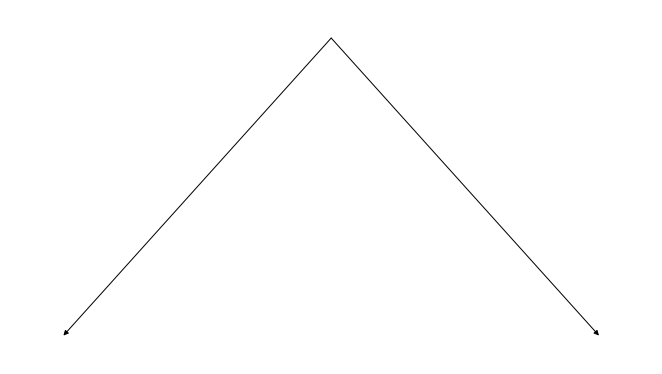

In [ ]:
adjacent_swaps={'(1,2)(-2,-1)' : 1}
one_gap_swaps= {'(1,3)(-3,-1)' : 1}
two_gap_swaps= {'(1,4)(-4,-1)' : 1}  
two_region_adjacent_transpositions={'(1,2)(-2,-1)' : 0.25, # Transposition where neither region is inverted
	'(1,2,-1,-2)'  : 0.25, # Transposition where the second region is inverted
	'(1,-2,-1,2)'  : 0.25, # Transposition where the first region is inverted
	'(1,-1)(2,-2)' : 0.25}
all_inversions={'(1,-2)(2,-1)':0.5,
                '(1,-1)': 0.5}
one_region_inversions={'(1,-1)':1}
two_region_inversions={'(1,-2)(2,-1)':1}

newick_Dict=["(A:2,B:1);","(A:2,B:2);","(A:3,B:3);","(A:5,B:5);"]
model_Dict=[all_inversions, one_gap_swaps,two_region_adjacent_transpositions,\
            one_region_inversions, two_region_inversions, adjacent_swaps]
number=[7]
my_sim("(A:1,B:1);", 50, all_inversions, all_inversions, 7)
for newick in newick_Dict:
    for numbers in number:
        for model in model_Dict:
            res=dict()
            for key in model:
                res[key] = round(model[key], 2)
            my_sim(newick, 50, res, res, numbers)
            





In [ ]:
for key in test_dict:
     
    # rounding to K using round()
    res[key] = round(test_dict[key], K)